# Part 0: Import data and libraries

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
!pip install datatile
from datatile.summary.df import DataFrameSummary
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")
df.shape
#We have 1338 samples in our dataset

(1338, 7)

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Part 1: EDA

# 1.1 Summary statistics

In [4]:
#Summary statistics
dfs = DataFrameSummary(df)
dfs.columns_stats
#From the columns statistics we see that there are in total 1338 samples.
#Also, there is no missing value.
#We find two bool values and one categorical value, all of which should be turned into binary values.

,age,sex,bmi,children,smoker,region,charges
counts,1338,1338,1338,1338,1338,1338,1338
uniques,47,2,548,6,2,4,1337
missing,0,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%
types,numeric,bool,numeric,numeric,bool,categorical,numeric


# 1.2 Visualization

<AxesSubplot:xlabel='charges'>

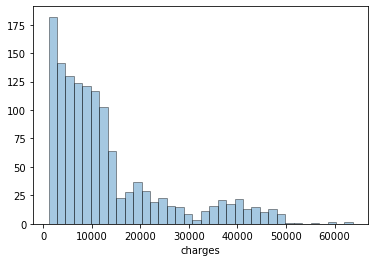

In [5]:
#Plot "charges" in bar chart
sns.distplot(df['charges'], hist=True, kde=False, bins=int(180/5), hist_kws={'edgecolor':'black'})

From the barchart, we see that most of the charges are around $ 10,000. Also, the distribution of "charges" does not follow a normal or uniform distribution, it would be better to change it to normal by taking log().

In [6]:
#Change "charges" to normal distribution by taking log
df['charges']=np.log(df['charges'])

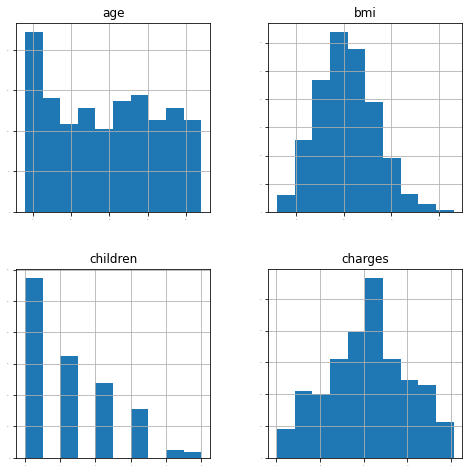

In [7]:
#Histograms of numerical features
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(8,8))
pyplot.show()

From the distribution, we see that now the target "charges" has a close to normal distribution

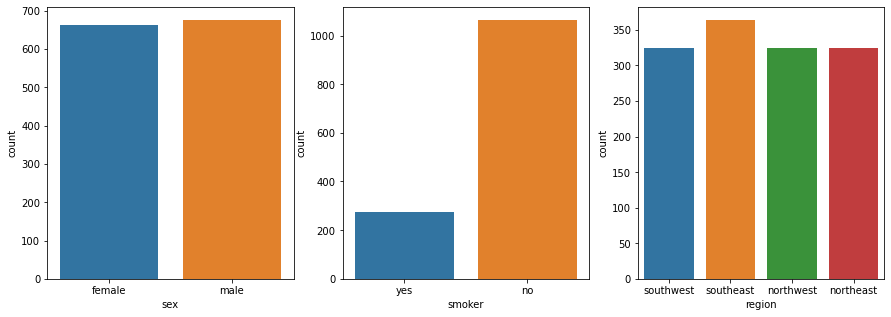

In [8]:
#Distribution plot of categorical features
fig, ax =plt.subplots(1,3,figsize=(15,5))
sns.countplot(df['sex'], ax=ax[0])
sns.countplot(df['smoker'], ax=ax[1])
sns.countplot(df['region'], ax=ax[2])
plt.show()

From the barchart, we see that among all of the customers, the number of females and males is similar;
more are smokers;
the most of people are from the southeast region.

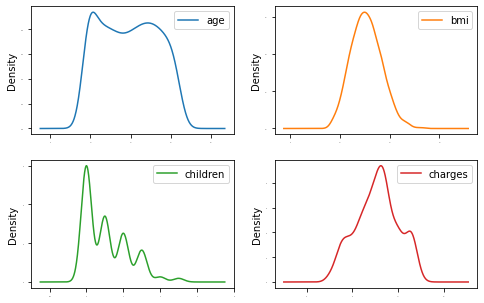

In [9]:
#Density plot of numerical features
df.plot(kind='density', subplots=True, layout=(3,2), sharex=False, legend=True, fontsize=1, figsize=(8,8))
pyplot.show()
#The density plots show that the distribution plot is correct.

<AxesSubplot:title={'center':'Correlation Matrix'}>

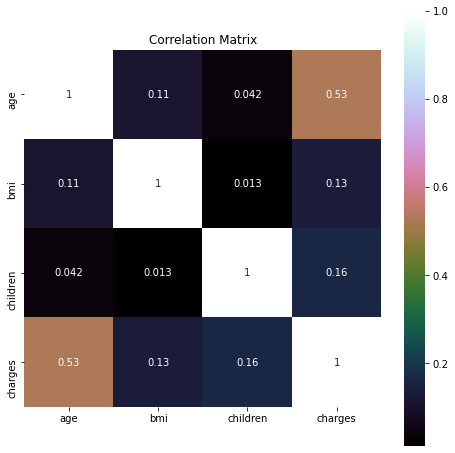

In [10]:
#Before handling categorical features, show the correlation between numerical features to have a overview
#Correlation between numerical features and target
correlation = df.corr()
pyplot.figure(figsize=(8,8))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

From the correlation matrix, we see that charges are positively correlated with all three features, i.e children, bmi and age. Among these numerical features, charges is most correlated with age.

<Figure size 576x576 with 0 Axes>

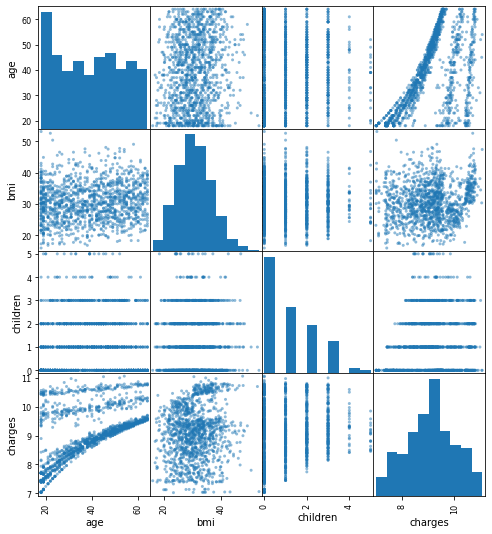

In [11]:
#Scatterplot of numerical features and target
pyplot.figure(figsize=(8,8))
scatter_matrix(df,figsize=(8,9))
pyplot.show()

From the scatter plot, we can observe the overall distribution of the data and the approximate relation between features and target

# 1.3 Detect outliers, duplicates and null values

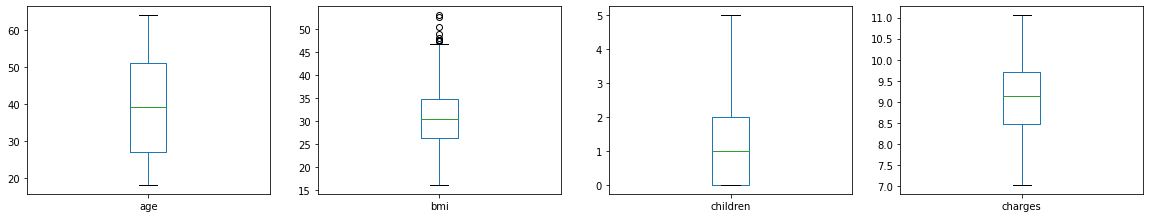

In [12]:
#We need to see if there exists many outliers in our dataset
#Detect outliers in numerical features using Box Plot
df.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(20,20))
pyplot.show()

<AxesSubplot:xlabel='bmi'>

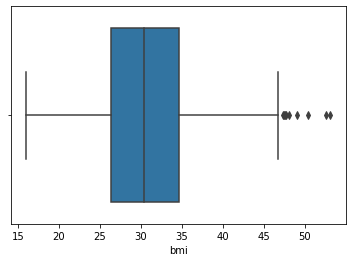

In [13]:
#Boxplot of feature 'bmi'
sns.boxplot(df['bmi'])

We notice that feature "bmi" has some outliers.

In [14]:
#Detect the number of outliers in bmi
def outlier_detect(data,col,threshold="",method=""):
  
    if method == "IQR":
      IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
      Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
      Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    if method == "STD":
      Upper_fence = data[col].mean() + threshold * data[col].std()
      Lower_fence = data[col].mean() - threshold * data[col].std()   
   
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Num of outlier detected:',outlier_index.value_counts()[1])
    print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))
    
    return outlier_index, para
#Use the 'STD' method with 3 standard deviation
index,para = outlier_detect(df,"bmi",threshold=3,method="STD")
print('Upper bound:',para[0],'\nLower bound:',para[1])

Num of outlier detected: 4
Proportion of outlier detected 0.0029895366218236174
Upper bound: 48.95795759602359 
Lower bound: 12.368836125949485


In [15]:
#As only few outliers, simply delete them from dataset
#Delete outliers from dataset using zscore and 3 std
df = df[(np.abs(stats.zscore(df['bmi'])) < 3)]
df.shape
#Now there are only 1334 samples

(1334, 7)

In [16]:
#Detect duplicates
df[df.duplicated(keep=False)]
#Since there is only one duplicate, it may be a coincidence. We keep the duplicates.

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,7.402185
581,19,male,30.59,0,no,northwest,7.402185


In [17]:
#Check if there exists null values
print('Null Values =',df.isnull().values.any())
#There is no null value.

Null Values = False


# Part 2: Data preprocessing

In this part, I conduct train/test split, normalization and standardization.

# 2.1 Train test split

I prepared two datasets, one for tree-based models and the other one for other models.

In [18]:
#Split the dataset into attributes and labels
Y=df["charges"]
X=df.loc[:, df.columns != 'charges']
#Train test split
validation_size=0.2
seed=5
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=validation_size, random_state=seed)
print(len(X_train), "train +", len(X_test), "test")

1067 train + 267 test


In [19]:
#Prepare new data set for tree-based models
X_train1 = X_train
X_test1 = X_test
Y_train1 = Y_train
Y_test1 = Y_test
#we summarize here that the data with _1 is for tree-based models

# 2.2 Convert unstructured data: Categorical Encoding

For tree-based models, label encoding is preferred; while for other models, one-hot encoding is preferred

In [20]:
#One hot encoding for other models, change categorical values into binary values
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[['sex','smoker','region']].values)
enc.fit(X_test[['sex','smoker','region']].values)

train = enc.transform(X_train[['sex','smoker','region']].values).toarray()
test = enc.transform(X_test[['sex','smoker','region']].values).toarray()
feature_labels = np.array(enc.categories_).ravel()

#Assemble column names with column name and value name
col_names = []
for col in ['sex','smoker','region']:
    for val in X_train[col].unique():
        col_names.append("{}_{}".format(col, val))

train = pd.DataFrame(data=train, columns=col_names, dtype=int)  
test = pd.DataFrame(data=test, columns=col_names, dtype=int)  
train.index = X_train.index
test.index = X_test.index

#Join together the new binary dataframe with the original one
X_train = pd.concat([X_train.iloc[:,[0,2,3]], train], axis=1)
X_test = pd.concat([X_test.iloc[:,[0,2,3]], test], axis=1)

In [21]:
#Another way to one hot encoding the categorical values using get_dummies
#x_train=pd.get_dummies(x_train, columns=['sex','smoker','region'])
#x_train

In [22]:
#LabelEncoder for tree-based models
cat_col = ['sex','smoker','region']
#Encode Categorical Columns
for cat in cat_col:
    le = LabelEncoder()
    X_train1[cat] = le.fit_transform(X_train1[cat])
    X_test1[cat] = le.transform(X_test1[cat])
#LabelEncoder is preferred to tree-based model as the trees cannot make precise judgement with dummy values(0-1)

# 2.3 Standardization

In [23]:
#Standardize train and test set respectively
sc = StandardScaler()
X_train.iloc[:,:] = sc.fit_transform(X_train.iloc[:,:].to_numpy())
X_test.iloc[:,:] = sc.transform(X_test.iloc[:,:].to_numpy())
#Standardization is not necessary for tree-based model

In [24]:
#Take X_train as an example to illustrate
X_train
#Until now, our dataset is ready for model construction
#i.e. X_train, Y_train, X_test, Y_test, X_train1, etc

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_southwest,region_southeast,region_northwest
760,-1.256940,0.634456,0.783615,1.012259,-1.012259,0.503805,-0.503805,1.744037,-0.551725,-0.609480,-0.574825
1286,-0.828387,-2.255744,-0.898713,1.012259,-1.012259,0.503805,-0.503805,1.744037,-0.551725,-0.609480,-0.574825
208,1.671502,0.169751,-0.898713,1.012259,-1.012259,0.503805,-0.503805,-0.573382,-0.551725,-0.609480,1.739659
439,-0.971238,-0.223076,-0.898713,-0.987890,0.987890,0.503805,-0.503805,1.744037,-0.551725,-0.609480,-0.574825
293,-1.256940,-0.328387,-0.898713,1.012259,-1.012259,0.503805,-0.503805,-0.573382,-0.551725,1.640744,-0.574825
...,...,...,...,...,...,...,...,...,...,...,...
73,1.314375,0.204854,-0.057549,-0.987890,0.987890,0.503805,-0.503805,-0.573382,-0.551725,1.640744,-0.574825
1145,0.885822,0.332732,1.624779,-0.987890,0.987890,0.503805,-0.503805,-0.573382,1.812496,-0.609480,-0.574825
1000,-0.685537,-1.302931,0.783615,-0.987890,0.987890,-1.984897,1.984897,-0.573382,1.812496,-0.609480,-0.574825
207,-0.328410,-0.508920,0.783615,-0.987890,0.987890,-1.984897,1.984897,1.744037,-0.551725,-0.609480,-0.574825


In [25]:
#Get features name
features_name=list(X_train.columns)

# 2.4 Correlation matrix with heat map

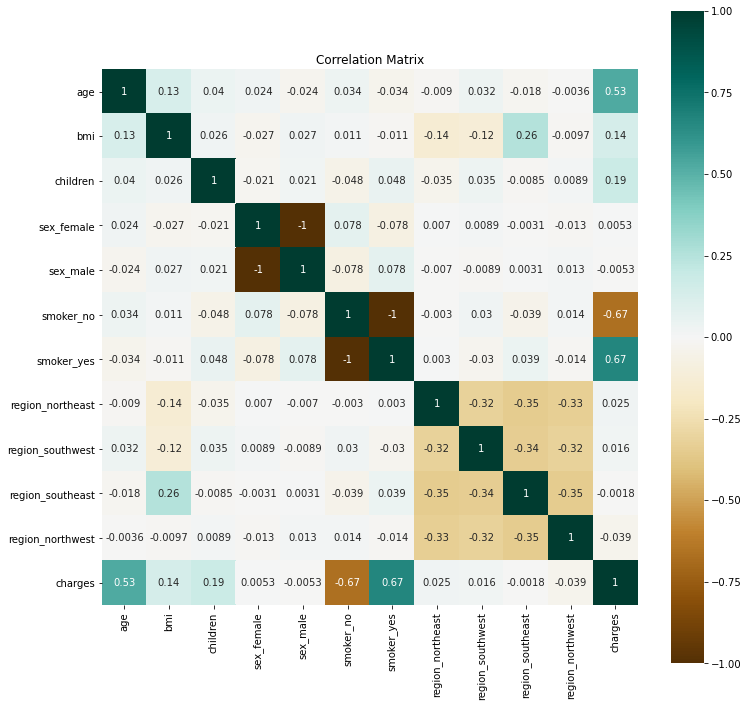

In [26]:
#Correlation matrix between features and target using X_train and Y_train
data = pd.concat([X_train, Y_train], axis=1)
correlation = data.corr()
pyplot.figure(figsize=(12,12))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='BrBG')
plt.show()

Between features and target, age, bmi, children, smoker_yes and smoker_no have a comparably strong correlation with charges.

Between features, regions are somewhat correlated with each other, which may give rise to a multicolinearity problem.

<AxesSubplot:title={'center':'Correlation Matrix'}>

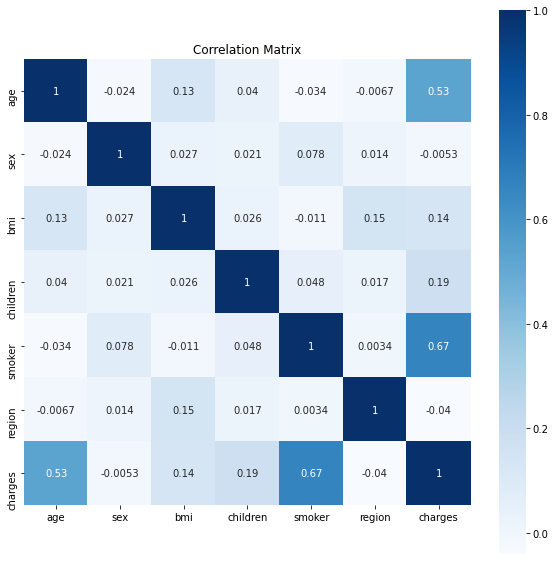

In [27]:
#Correlation matrix between features and target using x_train1 and y_train1 (data for tree-based models)
data1 = pd.concat([X_train1, Y_train1], axis=1)
correlation1 = data1.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation1, vmax=1, square=True,annot=True, cmap='Blues')

Between features and target, age, bmi, children and smoker have a comparably strong correlation with charges.

Between features, region and bmi, age and bmi are poorly correlated, and the correlation is not strong.

# Part 3: Model construction

In this part, six regression models are constructed and compared, namely: Linear regression(OLS), Gradient Boost Regression, Decision tree regression, Random forest regression, Neural network and KNN regression. All are supervised models.

I compared these regression models as followed. First, I conducted hyperparameters tuning to each alternative model, and selected the best hyperparameters within each model. Then, I used the trained model to predict X_test and compared the predicted results with y_test. Finally, I calculated the evaluation metrics (R-squared) of different models to choose the best model.

In [28]:
#Test options for all regression models
num_folds = 10
#The evaluation metric is R-squared
scoring = 'r2'
#General settings, use Kfold validation as the dataset is small
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# 3.1 Simple Multivariate linear regression

Simple linear regression is our first try to fit the data. It simply fits the data by minimizing MSE.

In [29]:
ols=LinearRegression(fit_intercept=True, normalize=False, copy_X=False)
ols.fit(X_train, Y_train)
r2_ols = ols.score(X_train, Y_train)
print('R2_OLS is:', r2_ols)
print('Intercept is:', ols.intercept_)
print('Slope is:', ols.coef_)
#The intercept and coefficients of the OLS model is printed. We obtained a R2 of 0.77322.

R2_OLS is: 0.7738884850009166
Intercept is: 9.105945881301414
Slope is: [ 4.86215684e-01  7.70778547e-02  1.20596287e-01 -1.39313260e+13
 -1.39313260e+13 -4.41280624e+12 -4.41280624e+12  4.17890161e+12
  4.09617720e+12  4.30369148e+12  4.18420093e+12]


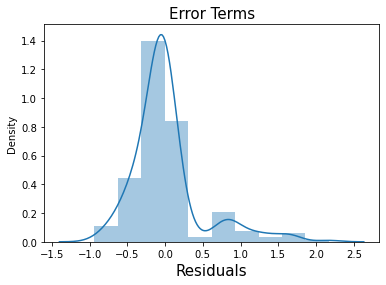

In [30]:
#Residuals plot
#For linear regression, it is always beneficial to plot the residuals.
Y_predict = ols.predict(X_test)
residuals = Y_test - Y_predict
sns.distplot(residuals, bins = 10) 
plt.title('Error Terms', fontsize=15)           
plt.xlabel('Residuals', fontsize = 15)     
plt.show()
#We see that the distribution of residuals are close to normal. 
#Therefore, a linear regression model is appropriate for the data.

# 3.2 Gradient Boosting Regression Model

Boosting in machine learning is a way of combining multiple simple models into a single composite model. It is also known as an additive model, since simple models (also known as weak learners) are added one at a time, while keeping existing trees in the model unchanged. As we combine more and more simple models, the complete final model becomes a stronger predictor. The GBR algorithm uses gradient descent to minimize the loss.

In [31]:
#Hyperparameters tuning using GridSearch CV, CV = Kfold
parameters={'n_estimators':[300,500,700,900],
            'learning_rate':[.001,0.01,.1],
            'max_depth':[1,2,3,4],'subsample':[.5,.75,1,1.25],'random_state':[1]}
gbm_grid = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=parameters,scoring=scoring,n_jobs=1,cv=kfold)
grid_result = gbm_grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#The scores for other non-optimal hyper-parameters are omitted here as they are too long
#The best hyperparameters are learning_rate=0.01, max_depth= 3, n_estimators=700, random_state= 1, subsample= 1

Best: 0.845815 using {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'random_state': 1, 'subsample': 1}


In [32]:
gbm=GradientBoostingRegressor(learning_rate=0.01, max_depth= 3, n_estimators=700, random_state= 1, subsample= 1)
gbm.fit(X_train,Y_train)
gbm_predict = gbm.predict(X_test)
r2_gbm = r2_score(Y_test, gbm_predict)
print('R2_GBM is:',r2_gbm)

R2_GBM is: 0.8089593567262068


# 3.3 Neural Network, MLP

Multi-layer Perceptron (MLP) learns a function by training on a dataset, given the number of dimensions for input and the number of dimensions for output. With a set of features and a target, it can learn a non-linear function approximator for regression. 

In [33]:
#Hyperparameters tuning using GridSearch CV, CV = Kfold
parameters={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
mlp_grid = GridSearchCV(estimator=MLPRegressor(), param_grid=parameters, scoring=scoring, cv=kfold)
grid_result = mlp_grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#The best hyperparameter is hidden_layer_sizes = (20, 30, 20)

Best: 0.783192 using {'hidden_layer_sizes': (20, 30, 20)}
0.374993 (0.147326) with: {'hidden_layer_sizes': (20,)}
0.687512 (0.074101) with: {'hidden_layer_sizes': (50,)}
0.730343 (0.050244) with: {'hidden_layer_sizes': (20, 20)}
0.783192 (0.064115) with: {'hidden_layer_sizes': (20, 30, 20)}


In [34]:
#Finalize model with best parameters found during tuning 
#Fit model with training set
mlp = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
mlp.fit(X_train,Y_train)
#Predict with test set and calculate the evalution metric (R2 scores)
mlp_predict = mlp.predict(X_test)
r2_mlp = r2_score(Y_test, mlp_predict)
print('R2_MLP is:', r2_mlp)

R2_MLP is: 0.773879131898628


# 3.4 KNN regression

KNN regression is a non-parametric method that approximates the association between features and target by averaging the observations in the same neighbourhood.
KNN works well with low dimension, i.e. a few features


In [35]:
#Hyperparameters tuning using GridSearch CV, CV = Kfold
knn_grid=GridSearchCV(estimator=KNeighborsRegressor(),param_grid={'n_neighbors':np.arange(5,13)},scoring=scoring,cv=kfold)
grid_result = knn_grid.fit(X_train,Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#The best hyperparameter is n_neighbors = 8

Best: 0.802019 using {'n_neighbors': 8}
0.790473 (0.062440) with: {'n_neighbors': 5}
0.797923 (0.060223) with: {'n_neighbors': 6}
0.799466 (0.062079) with: {'n_neighbors': 7}
0.802019 (0.060340) with: {'n_neighbors': 8}
0.800386 (0.061133) with: {'n_neighbors': 9}
0.796827 (0.059727) with: {'n_neighbors': 10}
0.795722 (0.060970) with: {'n_neighbors': 11}
0.796368 (0.060428) with: {'n_neighbors': 12}


In [36]:
#Finalize model with best parameters found during tuning 
#Fit model with training set
knn=KNeighborsRegressor(n_neighbors=knn_grid.best_params_["n_neighbors"])
knn.fit(X_train,Y_train)
#Predict with test set and calculate the evalution metric (R2 scores)
knn_predict = knn.predict(X_test)
r2_knn = r2_score(Y_test, knn_predict)
print('R2_KNN is:', r2_knn)
#Since we have many features in our dataset, it is not suprised that the KNN model doesn't fit well comparably.

R2_KNN is: 0.7691725635541161


# 3.5 Random Forest regression

Random Forest regression operates by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction of the individual trees. A random forest aggregates many decision trees with some helpful modifications and combines into a single ensemble model that ends up outperforming any individual decision tree’s output.

In [37]:
#Hyperparameters tuning using GridSearch CV, CV = Kfold
rf_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [530,540,550,560,570]}, scoring=scoring, cv=kfold)
grid_result = rf_grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#The best hyperparameter is n_estimators = 550

Best: 0.819884 using {'n_estimators': 550}
0.818891 (0.054261) with: {'n_estimators': 530}
0.818159 (0.055151) with: {'n_estimators': 540}
0.819884 (0.054098) with: {'n_estimators': 550}
0.819844 (0.054361) with: {'n_estimators': 560}
0.818236 (0.054780) with: {'n_estimators': 570}


In [38]:
#Finalize model with best parameters found during tuning 
#Fit model with training set
rf=RandomForestRegressor(n_estimators=rf_grid.best_params_["n_estimators"])
rf.fit(X_train,Y_train)
#Predict with test set and calculate the evalution metric (R2 scores)
rf_predict = rf.predict(X_test)
r2_rf = r2_score(Y_test, rf_predict)
print('R2_RF is:',r2_rf)

R2_RF is: 0.7732251747262437


# 3.6 Decision Tree regression

Decision Tree regression breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. It is useful for handling non-linear data sets effectively. 

In [39]:
#hyperparameters tuning using GridSearch CV, CV = Kfold
parameters={"splitter":["best","random"],
            "max_depth" : [3,4,5,6,7],
           "min_samples_leaf":[4,5,6,7],
           "min_weight_fraction_leaf":[0,0.1,0.2,0.3],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[20,25,30,35,40] }
#Hyperparameters tuning using GridSearch CV
dt_grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=parameters, scoring=scoring, cv=kfold)
grid_result = dt_grid.fit(X_train1, Y_train1)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#The scores for other non-optimal hyper-parameters are omitted here as they are too long
#The best hyperparameters are splitter='best', max_depth=6, min_samples_leaf=4, min_weight_fraction_leaf=0.0, max_features='auto', random_state=None, max_leaf_nodes=25

Best: 0.843026 using {'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': 25, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


In [40]:
#Finalize model with best parameters found during tuning 
#Fit model with training set
dt=DecisionTreeRegressor(splitter='best', max_depth=6, min_samples_leaf=4, min_weight_fraction_leaf=0.0, max_features='auto', random_state=None, max_leaf_nodes=25)
dt.fit(X_train1,Y_train1)
#Predict with test set and calculate the evalution metric (R2 scores)
dt_predict = dt.predict(X_test1)
r2_dt = r2_score(Y_test1, dt_predict)
print('R2_DT is:', r2_dt)

R2_DT is: 0.7600132737777447


# 4 Conclusion

# 4.1 Comparisons between models

In [41]:
#Put all scores in one dataframe
result={'OLS':[r2_ols],'GradientBoostingModel':[r2_gbm],'NN_MLP':[r2_mlp],'KNN':[r2_knn],'RandomForest':[r2_rf],'DecisionTree':[r2_dt]}
result = pd.DataFrame(result)
result.columns.name = 'R2'
result

R2,OLS,GradientBoostingModel,NN_MLP,KNN,RandomForest,DecisionTree
0,0.773888,0.808959,0.773879,0.769173,0.773225,0.760013


From the above table we can clearly see that Gradient Bossting Regression model fits the data best with the highest R-squared scores.
The best model is a GBR model with 700 estimators, learning_rate=0.01, max_depth= 3, random_state= 1, subsample= 1.

# 4.2 Gradient Boosting Regressor model results analysis

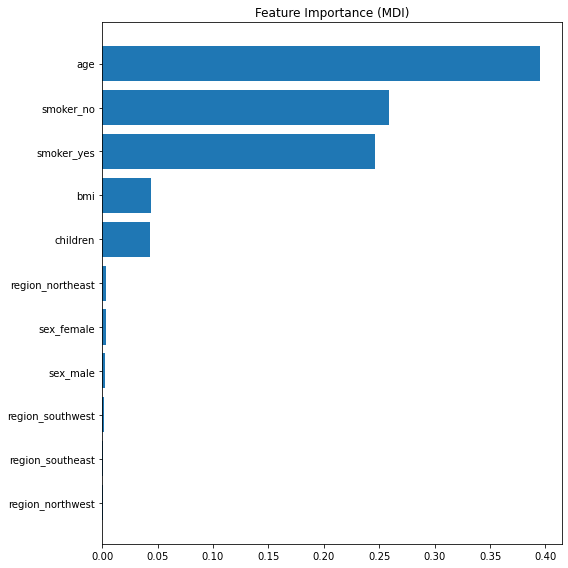

In [42]:
#Get feature importance using feature_importances_ attribute
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features_name)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(gbm, X_test, Y_test, n_repeats=10,
                                random_state=1, n_jobs=1)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

From the above chart, we see that from the GBR model, age, smoker_no, smoker_yes, bmi and children are the important features in determining insurance charges. Among these features, age is the most important factor, followed by smoker. The region where customers live and gender are of little importance. 

These findings are close to the reality. We may get some insights from this: When deciding the charges for customers, "age" should be the first and foremost factor to consider. Then, one should take whether smoking or not into consideration. Thirdly, considering bmi and numeber of children. Gender and living regions should pay little attention to. The focus should be on age, smoking habit, bmi and numeber of children.

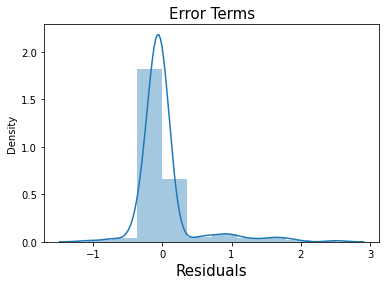

In [43]:
#Residual plots of Gradient Boosting Regression
gbm_predict = gbm.predict(X_test)
residuals = Y_test - gbm_predict
sns.distplot(residuals, bins = 10) # you may select the no. of bins
plt.title('Error Terms', fontsize=15)           
plt.xlabel('Residuals', fontsize = 15)     
plt.show()
#We see that the distribution of residuals are close to normal. 
#Therefore, a GBR model is appropriate for our data

In this work, however, there are uncertainties in the hyperparameters tuning step. For the range of parameters for Gridsearch, I gave some values just by guess. It is possible that the value I gave are not around the best choice. In reality, one should test on different combinations.